In [11]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
wine_quality = fetch_ucirepo(id=186)

# Pre-processing
df = wine_quality.data.original

def categorize_quality(quality):
    if quality < 7:
        return 'low'
    else:
        return 'high'


df['quality_category'] = df['quality'].apply(categorize_quality)

red_wine_df = df[df['color'] == 'red']
white_wine_df = df[df['color'] == 'white']

df_array = [red_wine_df, white_wine_df, df]



In [13]:

rf = RandomForestClassifier(random_state=42)
df_names = ['Red Wine', 'White Wine', 'Combined Wine']

def confusion_matrix_plot(y_test, y_pred, clf, model):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for DataFrame {model.__class__.__name__}')
    plt.show()

def optimized_folds(model, X, y):
    best_score = 0
    best_folds = 0
    
    for folds in np.arange(2, 11):
        scores = cross_val_score(model, X, y, cv=folds, scoring='f1_macro')
        if scores.mean() > best_score:
            best_score = scores.mean()
            best_folds = folds
    
    print(f"Best Folds: {best_folds} | Best Score: {best_score}", end=" | ")
    return best_folds





Processing Red Wine DataFrame
Best Folds: 9 | Best Score: 0.6854182647328406 | Fitting 9 folds for each of 10 candidates, totalling 90 fits
Best parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15, 'bootstrap': False}
              precision    recall  f1-score   support

        high       0.69      0.51      0.58        65
         low       0.93      0.96      0.94       415

    accuracy                           0.90       480
   macro avg       0.81      0.74      0.76       480
weighted avg       0.89      0.90      0.90       480



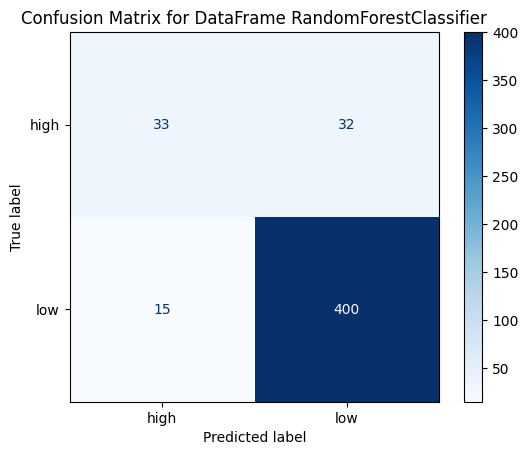


Processing White Wine DataFrame
Best Folds: 6 | Best Score: 0.6677103280934079 | Fitting 6 folds for each of 10 candidates, totalling 60 fits
Best parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15, 'bootstrap': False}
              precision    recall  f1-score   support

        high       0.79      0.59      0.68       318
         low       0.89      0.96      0.92      1152

    accuracy                           0.88      1470
   macro avg       0.84      0.77      0.80      1470
weighted avg       0.87      0.88      0.87      1470



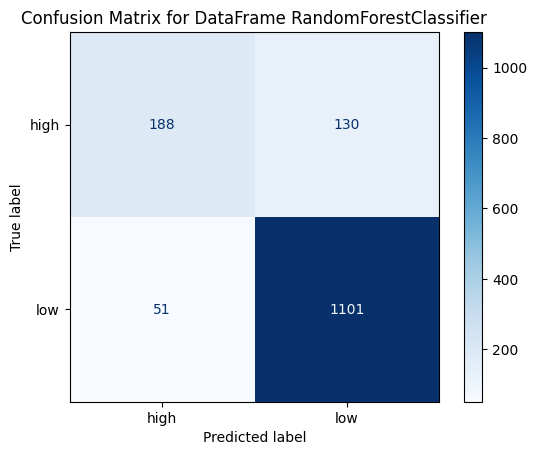


Processing Combined Wine DataFrame
Best Folds: 9 | Best Score: 0.6534978641621876 | Fitting 9 folds for each of 10 candidates, totalling 90 fits
Best parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15, 'bootstrap': False}
              precision    recall  f1-score   support

        high       0.78      0.56      0.65       383
         low       0.90      0.96      0.93      1567

    accuracy                           0.88      1950
   macro avg       0.84      0.76      0.79      1950
weighted avg       0.88      0.88      0.87      1950



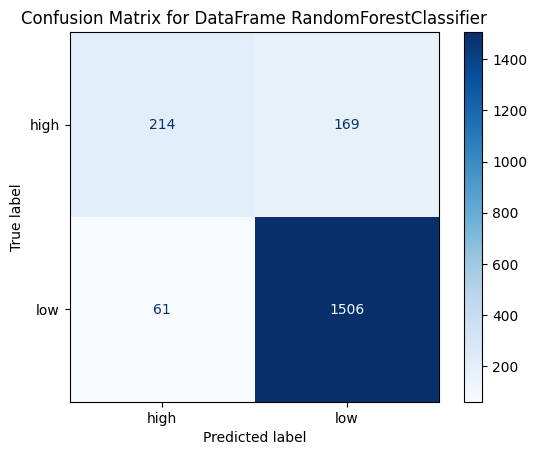

In [14]:
for i, df in enumerate(df_array):
    print("=" * 40)
    print(f"Processing {df_names[i]} DataFrame")
    print("=" * 40)
    
    X = df.drop(['quality', 'quality_category', 'color'], axis=1)
    y = df['quality_category']

    fold_options = np.arange(5, 15)
    best_folds = optimized_folds(rf, X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Randomized Search CV (faster alternative to Grid Search)
    param_dist = {
        'n_estimators': np.arange(50, 300, 50),
        'max_depth': [None] + list(np.arange(5, 50, 5)),
        'min_samples_split': np.arange(2, 20, 2),
        'min_samples_leaf': np.arange(1, 10, 1),
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    }

    rf = RandomForestClassifier(random_state=42)

    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        cv=best_folds,
        n_jobs=-1,  # Use all available cores
        scoring='accuracy',
        random_state=42,
        verbose=1 # how much output to show during the search
    )

    random_search.fit(X_train, y_train)

    print(f"Best parameters: {random_search.best_params_}")

    # Evaluation metrics
    y_pred = random_search.predict(X_test)

    print(classification_report(y_test, y_pred))
    confusion_matrix_plot(y_test, y_pred, random_search, rf)